In [3]:

#import modules
import numpy as np   #for calculations
import matplotlib.pyplot as plt  #for plotting
%matplotlib inline  
import pandas as pd  #for reading in data
import datetime    #for manipulation by dtae
import collections  #for additional dictionary functionality
from matplotlib.gridspec import GridSpec #for subplots
import scipy.signal as signal #for signal processing
import scipy.stats as stats
import xarray as xr
print('finished...')

finished...


## Read in data

In [52]:
## read in data, pull variables, delete file to save memory
NWF = xr.open_zarr('/projects/oswwra/N_Atl/Zarr_files/NWF/final.zarr') # no wind farm

NWF
hgt       = NWF['height']
lat       = NWF['lat'][200, 50] # grab at a coordinate over land
lon       = NWF['lon'][200, 50] # grab at a coordinate over land
times     = NWF['time'][::6] 
# # Read in potential temperature
wdir      = NWF['WDIR'][::6,0,200,50] # hourly, use the lowest level so diurnal effects are amplfied
n_times   = len(times)
del NWF




# Plot raw wind direction

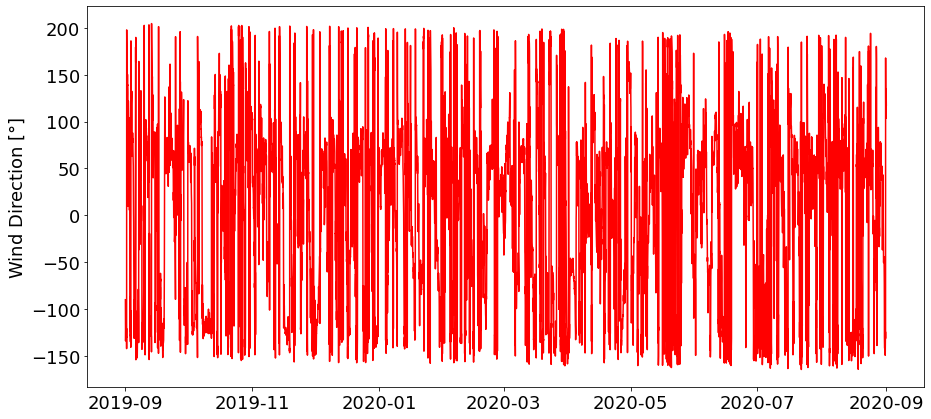

In [53]:
## Process the data

# detrend the data since the FFT assumes stationarity
data = signal.detrend(wdir,type='linear')

# Plot raw data
fs = 18
fig,ax = plt.subplots(1,1,figsize=(15,7))
ax.plot(times,data, c='red')
ax.set_ylabel('Wind Direction [$\degree$]', fontsize=fs)
ax.tick_params(labelsize=fs)




In [54]:
# get anomalous quantities
data = data-data.mean()


## Calculate the power spectrum of red noise with lag1_r to use for significance testing
alpha = 0.99 ## set statistical significance level

### step 1: calculate lag-1 autocorrelation (lag1_r, rho) and the associated p value (lag1_p)
lag1_r,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)])

### step 2: Calculate e-folding time for a red-noise process with this lag-1 autocorrelation
Te = -1./np.log(lag1_r) # After Hartman 6.62 with delta t = 1
print('lag-1 autocorrelation =',round(lag1_r,2),'and Te =',round(Te,0))


def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)
def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,100000) # Note: 200 = large degree of freedom for red noise
    return f_ratio*red_fit_n

## calculate the power spectrum of red noise with lag1_r to use for significance testing
red_fit_n = create_normalized_redfit(len(data),Te)
dof_entirewindow = 2 ### note dof=2 because using whole record for FFT with no chunking
f_bounds = create_f_bounds(alpha,dof_entirewindow,red_fit_n)  ## using f-test for variance, see function
## multiple DOF by 1.2 to account for extra smoothing Hanning (Barnes Ch. 4 Eq. 59)
## For the homework we just multiply by 1
f_bounds_hanning = create_f_bounds(alpha,dof_entirewindow*1.,red_fit_n)  

lag-1 autocorrelation = 0.76 and Te = 4.0


1197
DOF = 7.344481605351171

maximum amplitude of power: 0.021172
frequency of maximum power: [0.00334448] 

frequency range of stat. sign. power: 0.0008361204013377926 to 0.4995819397993311 

frequency range of stat. sign. power: [0.00083612 0.00292642 0.00334448 0.01086957 0.04180602 0.15259197
 0.25250836 0.25292642 0.2562709  0.26128763 0.27424749 0.28302676
 0.31270903 0.32316054 0.3298495  0.33904682 0.34155518 0.34406355
 0.34824415 0.35451505 0.35493311 0.35744147 0.36120401 0.36496656
 0.36705686 0.36831104 0.36914716 0.36998328 0.3729097  0.37332776
 0.37374582 0.37625418 0.37667224 0.37792642 0.38001672 0.3812709
 0.38419732 0.38503344 0.38628763 0.38670569 0.38837793 0.38879599
 0.39548495 0.39757525 0.39882943 0.39924749 0.40259197 0.40551839
 0.40635452 0.40719064 0.4076087  0.40802676 0.40928094 0.409699
 0.41220736 0.41304348 0.41346154 0.4138796  0.41429766 0.4159699
 0.41722408 0.41764214 0.41973244 0.4201505  0.42098662 0.42182274
 0.42265886 0.42349498 0.42391304 0

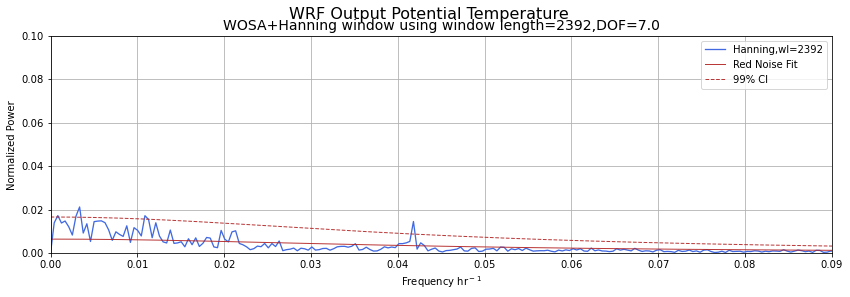

In [65]:
## Use the Hanning Window AND change the length of the data window AND use WOSA (Welch’s Overlapping Segment Analysis)
# The maximum frequency we care about is daily.  So use windows of length 24 hours
window_length = 2392
#window_length = 24
T2 = window_length/2 
freq_w = np.arange(0.,T2+1.)/window_length
#print(len(freq))
P_welch = signal.welch(data,window='boxcar',nperseg=window_length); # hanning,boxcar
#print(np.size(P_welch))
P_welch_n = P_welch[1]/np.sum(P_welch[1])  #normalize

## Construct the expected rednoise spectrum - functions
## Need to update the 99% confidence interval - we have more DOF
red_fit_n_welch = create_normalized_redfit(window_length,Te)  ## generate red_fit_n using window_length
print(np.size(red_fit_n_welch))
dof_welch=len(data)/(window_length/2)  ### Barnes Eq. 59, factor fw=?, using more of the data so not multiplying by 1.2
print('DOF =',dof_welch)
print()
f_bounds_welch = create_f_bounds(alpha,dof_welch,red_fit_n_welch)  ## f-test for variance; 

## plot
fig = plt.figure(figsize=(14,4))
plt.xlabel('Frequency hr$^-$$^1$')
plt.ylabel('Normalized Power')
plt.ylim(0.0,0.1)
plt.xlim(0.0,0.09)
plt.grid()
plt.plot(freq_w,P_welch_n, color='royalblue', lw=1.3, label='Hanning,wl='+str(window_length));
plt.plot(freq_w,red_fit_n_welch, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit');
plt.plot(freq_w,f_bounds_welch, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI');
plt.suptitle('WRF Output Potential Temperature', fontsize=16)
plt.title("WOSA+Hanning window using window length="+str(window_length)+",DOF="+str(round(dof_welch,0)),fontsize=14);
plt.legend()


# get maximum amplitude of power
print('maximum amplitude of power:', P_welch_n.max())

# get frequency of maximum power
flag1 = np.where(P_welch_n==np.max(P_welch_n))
print('frequency of maximum power:', freq_w[flag1], '\n')

flag2 = np.where(P_welch_n>f_bounds_welch)
print('frequency range of stat. sign. power:', freq_w[flag2].min(),'to',freq_w[flag2].max(),'\n')
print('frequency range of stat. sign. power:', freq_w[flag2])




In [56]:
print(len(data))

8784
